Window size 1: MSE = 0.0046
Window size 2: MSE = 0.0036
Window size 3: MSE = 0.0034
Window size 4: MSE = 0.0033
Window size 5: MSE = 0.0033
Window size 6: MSE = 0.0033
Window size 7: MSE = 0.0034
Window size 8: MSE = 0.0034
Window size 9: MSE = 0.0034
Window size 10: MSE = 0.0034
Window size 11: MSE = 0.0035
Window size 12: MSE = 0.0035
Window size 13: MSE = 0.0036
Window size 14: MSE = 0.0037
Window size 15: MSE = 0.0037
Window size 16: MSE = 0.0038
Window size 17: MSE = 0.0038
Window size 18: MSE = 0.0039
Window size 19: MSE = 0.0039
Window size 20: MSE = 0.0040
Window size 21: MSE = 0.0040
Window size 22: MSE = 0.0041
Window size 23: MSE = 0.0041
Window size 24: MSE = 0.0042
Window size 25: MSE = 0.0042
Window size 26: MSE = 0.0042
Window size 27: MSE = 0.0042
Window size 28: MSE = 0.0043
Window size 29: MSE = 0.0043
Window size 30: MSE = 0.0044
Window size 31: MSE = 0.0044
Window size 32: MSE = 0.0044
Window size 33: MSE = 0.0045
Window size 34: MSE = 0.0045
Window size 35: MSE = 0

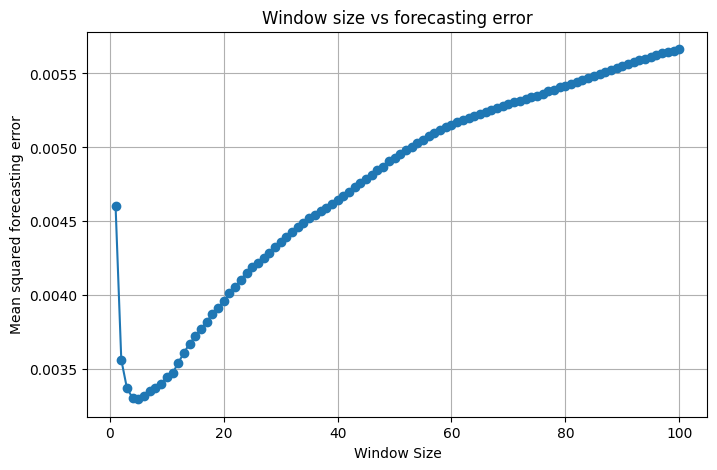

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD  # or from emd import sifting
from scipy.signal import hilbert

csv_file = '../../data/datav.csv'
df = pd.read_csv(csv_file)
X = df['volatility'].values

# EMD
emd = EMD()
imfs = emd.emd(X)

# Hilbert transform
sampling_interval = 1.0  # delta for the data
all_amplitudes = []
all_frequencies = []

for imf in imfs:
    analytic_signal = hilbert(imf)
    amplitude = np.abs(analytic_signal)
    phase = np.unwrap(np.angle(analytic_signal))
    
    freq = np.diff(phase) / sampling_interval
    
    all_amplitudes.append(amplitude)
    all_frequencies.append(freq)



all_powers = [amp**2 for amp in all_amplitudes]



def modeling_error(X, window_size):
    N = len(X)
    if window_size >= N:
        return np.inf

    errors = []
    for t in range(0, N - window_size):
         window = X[t:t+window_size]
         forecast = np.mean(window) 
         actual = X[t+window_size]
         errors.append((forecast - actual)**2)
    
    mse = np.mean(errors)
    return mse



candidate_windows = range(1, min(101, len(X)//2), 1)
errors = []

for w in candidate_windows:
    err = modeling_error(X, w)
    errors.append(err)
    print(f"Window size {w}: MSE = {err:.4f}")

optimal_window = candidate_windows[np.argmin(errors)]
print("\nOptimal window size (minimizing forecasting error):", optimal_window)

plt.figure(figsize=(8, 5))
plt.plot(candidate_windows, errors, marker='o', linestyle='-')
plt.xlabel("Window Size")
plt.ylabel("Mean squared forecasting error")
plt.title("Window size vs forecasting error")
plt.grid(True)
plt.show()

## New proposed dynamic method

In [ ]:
import numpy as np
from PyEMD import EMD
from scipy.signal import hilbert
from collections import Counter


In [ ]:
def compute_dynamic_windows(
    sig_R, sig_V,
    sampling_interval=1.0,
    max_period=200,
    min_energy_frac=0.05,
    eps=1e-8
):
    emd    = EMD()
    imfs_R = emd.emd(sig_R)
    imfs_V = emd.emd(sig_V)

    def signal_energy_period(imfs):
        all_amps, all_P = [], []
        for imf in imfs:
            analytic = hilbert(imf)
            amp      = np.abs(analytic)       
            phase    = np.unwrap(np.angle(analytic))
            omega    = np.diff(phase)/sampling_interval
            omega    = np.concatenate(([omega[0]], omega))
            min_omega = 2*np.pi/max_period
            omega     = np.maximum(np.abs(omega), min_omega) + eps
            P         = 2*np.pi/omega         
            all_amps.append(amp)
            all_P.append(P)

        A = np.stack(all_amps, axis=0)        # (n_imf, N)
        P = np.stack(all_P,    axis=0)        # (n_imf, N)

        energies = (A**2).sum(axis=1)         # (n_imf,)
        keep     = energies/energies.sum() > min_energy_frac
        A, P     = A[keep], P[keep]

        E_signal = (A**2).sum(axis=0)         # (N,)
        P_signal = ((A**2)*P).sum(axis=0) / (E_signal + eps)
        return E_signal, P_signal

    eR, PR = signal_energy_period(imfs_R)
    eV, PV = signal_energy_period(imfs_V)

    total_e = eR + eV + eps
    wR      = eR/total_e
    wV      = eV/total_e

    Pblend  = wR*PR + wV*PV
    tau     = np.ceil(Pblend).astype(int)
    return np.clip(tau, 1, max_period)



In [ ]:
import pandas as pd

df = pd.read_csv('../../data/dataV.csv')
sig_R = df['returns'].values      
sig_V = df['volatility'].values

tau = compute_dynamic_windows(sig_R, sig_V)

print(tau)

[    -1201     -1296 -11485294 ...      4059 -13179587      1255]


C:\Users\paula\AppData\Local\Temp\ipykernel_12616\2006935911.py:58: RuntimeWarning: invalid value encountered in cast
  tau_blend = np.ceil(P_blend).astype(int)


## Constant window new method

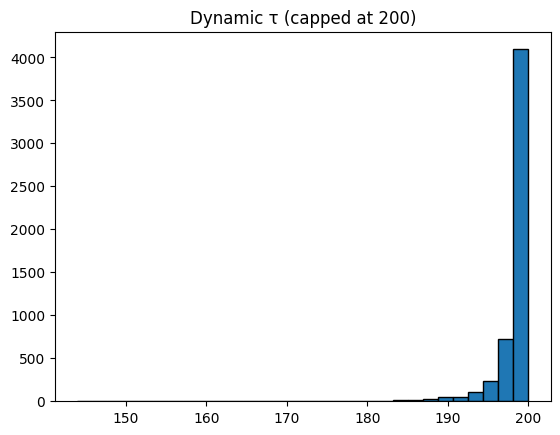

Fixed window (5–95% trimmed median): 200


In [10]:
def ideal_constant_window(
    tau_blend,
    method='trimmed_median',
    lower_q=0.05,
    upper_q=0.95
):
    
    if method=='median':
        return int(np.median(tau_blend))
    if method=='mean':
        return int(np.mean(tau_blend))
    if method=='mode':
        return Counter(tau_blend).most_common(1)[0][0]
    if method=='trimmed_median':
        lo = np.quantile(tau_blend, lower_q)
        hi = np.quantile(tau_blend, upper_q)
        valid = tau_blend[(tau_blend>=lo)&(tau_blend<=hi)]
        return int(np.median(valid))
    raise ValueError


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

df    = pd.read_csv('../../data/datav.csv')
sigR  = df['returns'].values
sigV  = df['volatility'].values

tau   = compute_dynamic_windows(
    sigR, sigV,
    max_period=200,
    min_energy_frac=0.05
)

plt.hist(tau, bins=30, edgecolor='k')
plt.title("Dynamic τ (capped at 200)")
plt.show()

fix_w = ideal_constant_window(tau, method='trimmed_median')
print("Fixed window (5–95% trimmed median):", fix_w)
